In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

3-1) Volume이 음수인 값 클리닝

In [2]:
vol = pd.read_pickle("ryu_new_volume.pickle") # 컬럼 드랍 다 했음
print(len(vol.columns))
(vol < 0).sum().sum()

9421


5

In [3]:
# 거래량이 음수인 데이터가 있다??
vol.loc["2021-07-07"].loc[(vol.loc["2021-07-07"] < 0).values]

BYN2       -9.312480e+06
FISH       -2.363013e+08
POLYDOGE   -7.449346e+09
STACK2     -4.893625e+05
WMATIC     -4.616286e+11
Name: 2021-07-07 00:00:00, dtype: float64

In [4]:
# Volume이 음수인 애들을 단순히 전날 값으로 ffill만 해주자
vol.loc["2021-07-07", ["BYN2","FISH","POLYDOGE","STACK2","WMATIC"]] = vol.loc["2021-07-06", ["BYN2","FISH","POLYDOGE","STACK2","WMATIC"]]

In [5]:
vol.loc["2021-07-07",["BYN2","FISH","POLYDOGE","STACK2","WMATIC"]]

BYN2         1615360.00
FISH         2099436.00
POLYDOGE      608461.00
STACK2           717.52
WMATIC      43278138.00
Name: 2021-07-07 00:00:00, dtype: float64

In [6]:
vol.to_pickle("ryu_new_volume2.pickle")

3-2)Paper와의 통계량이 일치하는 지 확인하자

In [7]:
mktcap = pd.read_pickle("ryu_new_mktcap2.pickle")
price  = pd.read_pickle("ryu_new_price.pickle")

rtn = price.pct_change(fill_method=None) * np.sign(price)

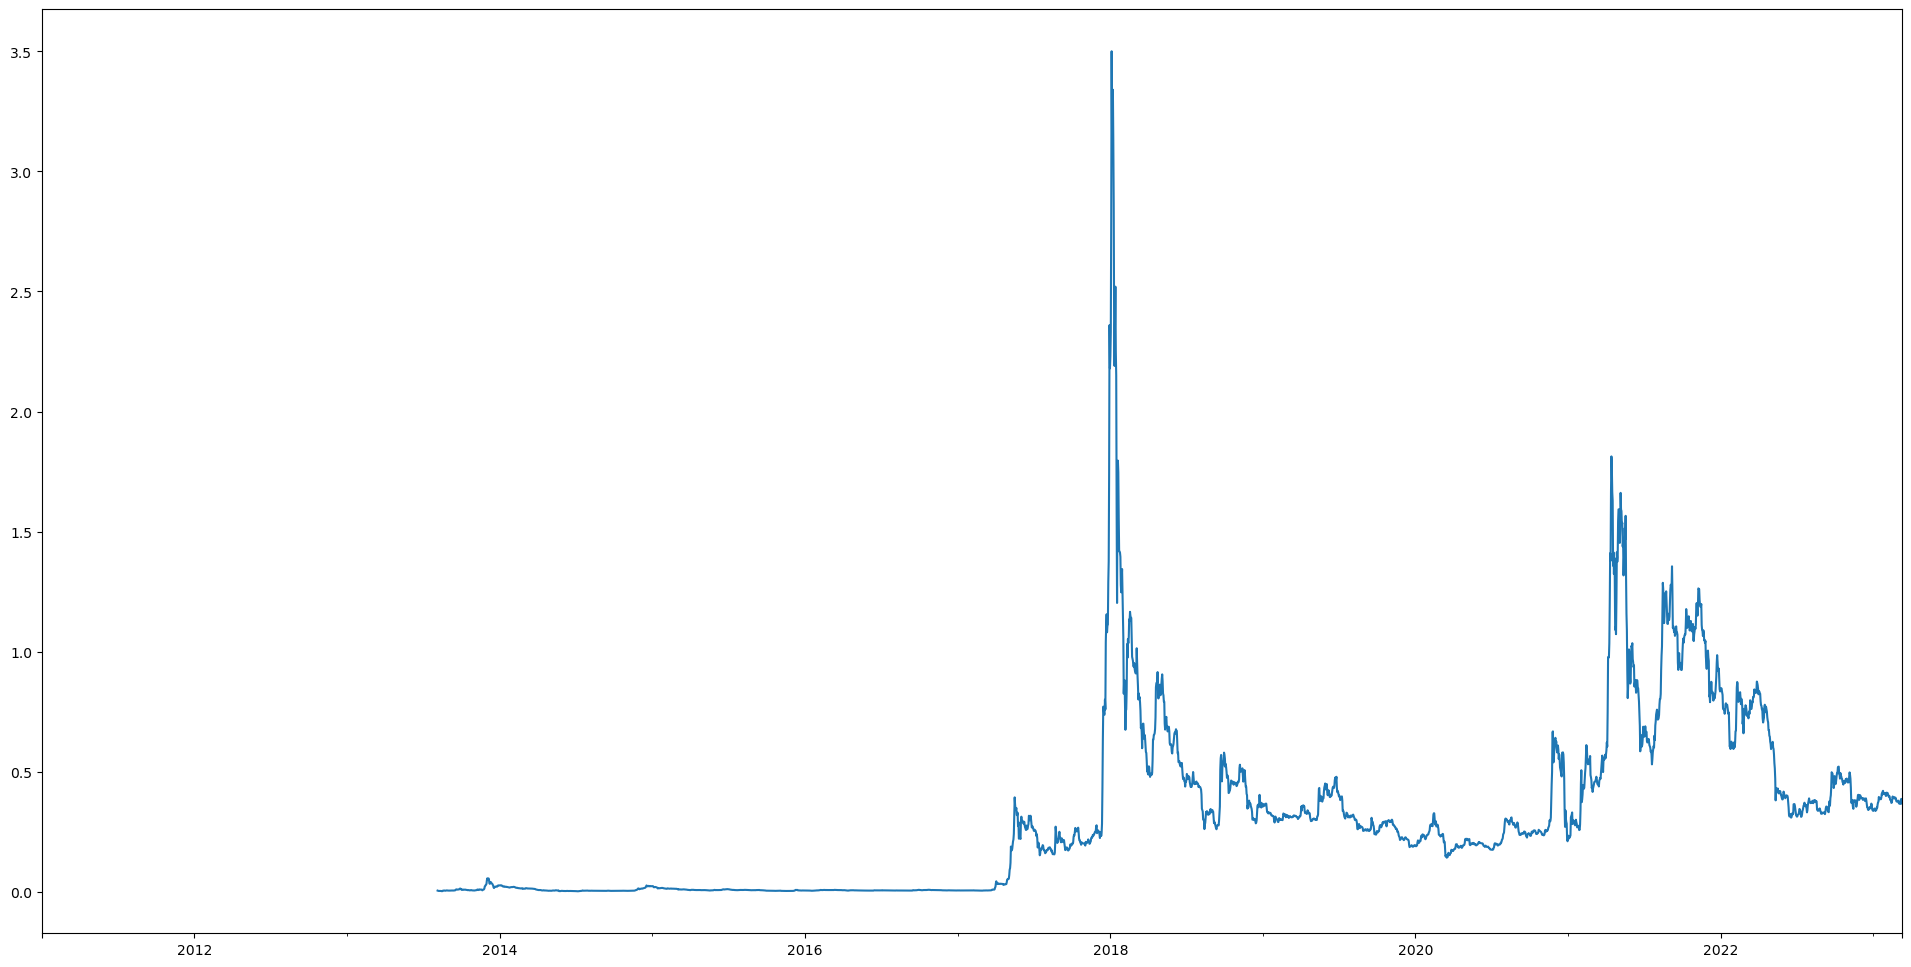

In [8]:
price.XRP.plot(figsize=(24,12));

In [9]:
# Paper의 데이터와 약간 다르군.....
rtn.loc["2011-01-01":"2018-12-31", ["BTC","ETH","XRP"]].agg(["mean","std"])

,BTC,ETH,XRP
mean,0.004485,0.005511,0.004292
std,0.050212,0.062755,0.069718


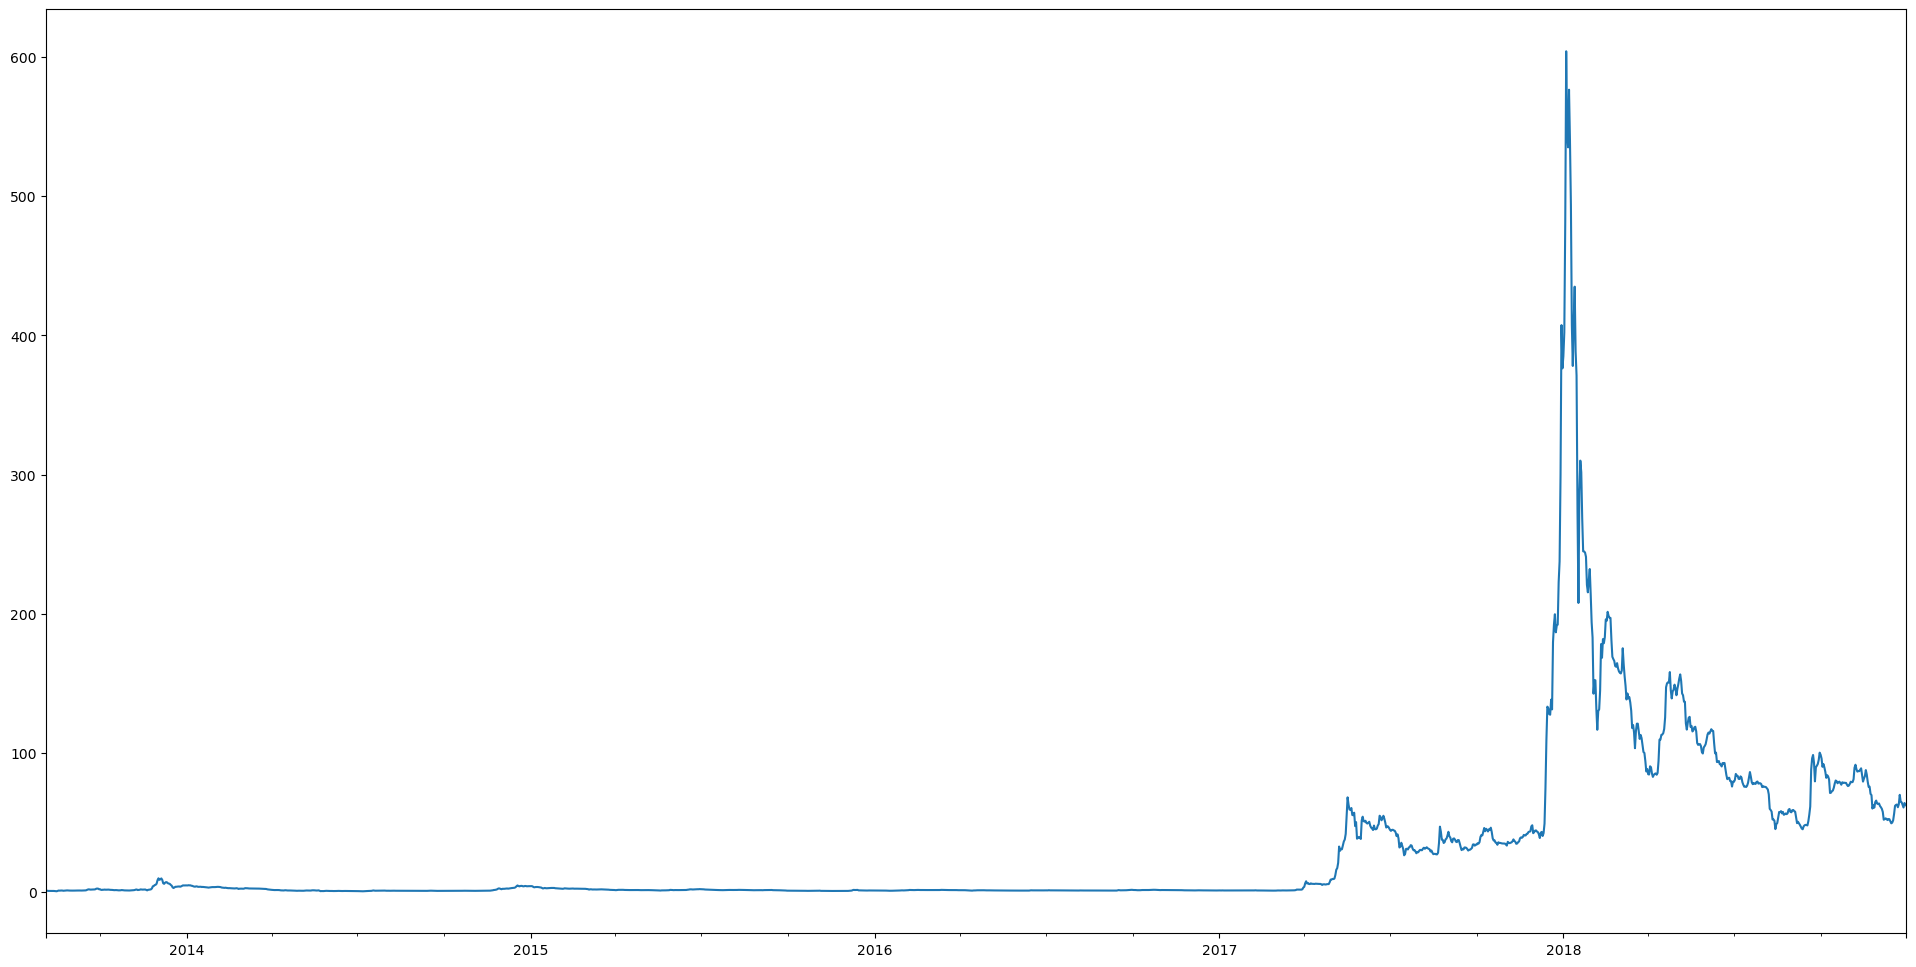

In [10]:
# 리플 그려보기
(rtn.XRP.loc["2013-08-05":"2018-12-31"].fillna(0) + 1).cumprod().plot(figsize=(24,12));

3-3) Volume이 NaN이 아닌 값들로만 스크리닝 해보자

In [11]:
vol = pd.read_pickle("ryu_new_volume2.pickle")

# Negative volume is removed by step 3-1
(vol < 0).sum().sum()

0

In [12]:
vol_mask = np.sign(vol).replace({1:True,
                                 0:True})

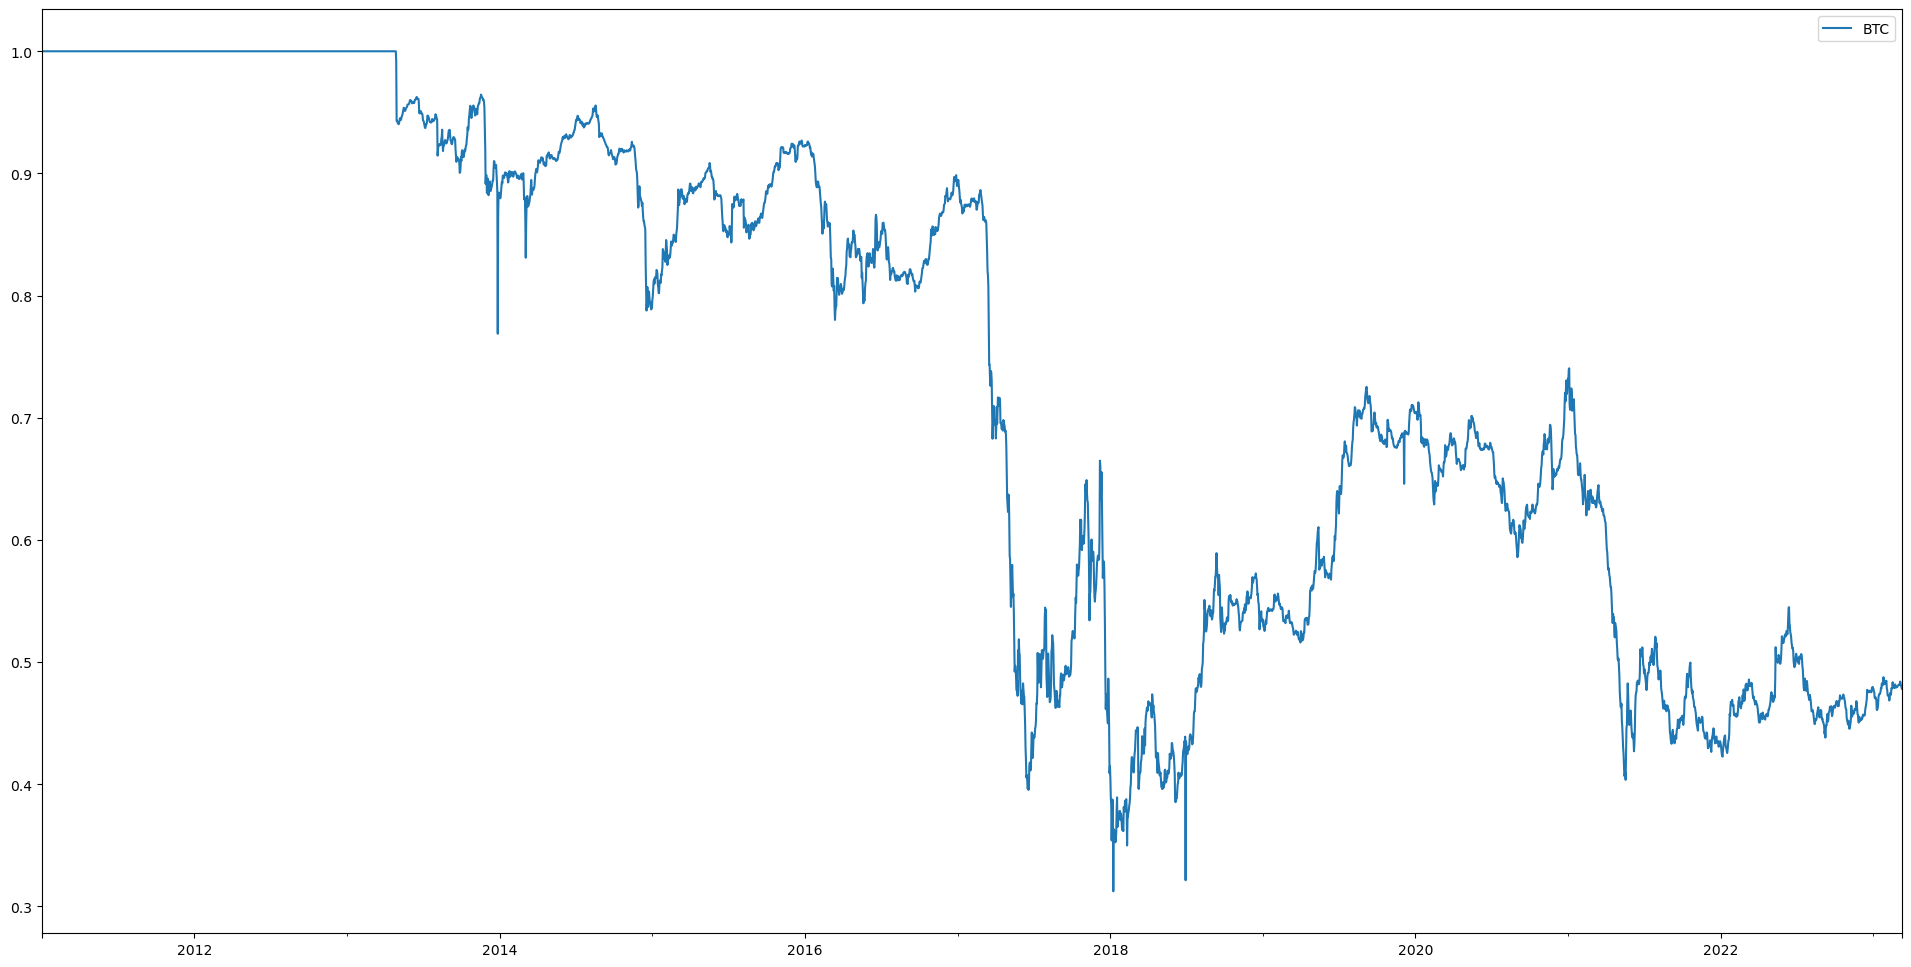

In [13]:
weight = (vol_mask*mktcap).apply(lambda x: x / np.nansum(x), axis=1)
weight[["BTC"]].plot(figsize=(24,12));

<AxesSubplot:>

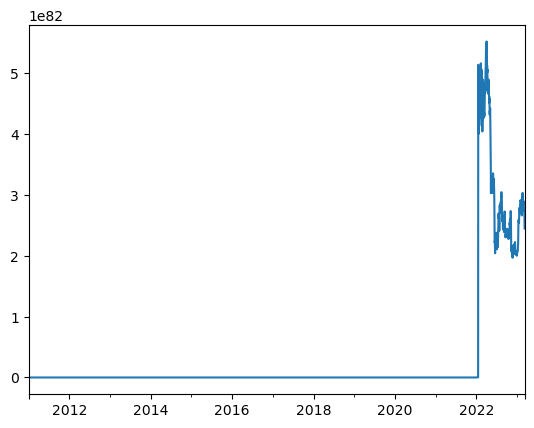

In [14]:
# 리턴찍어보자 -> 의미없는 스크리닝이다 라는 걸 확인했음....
((rtn * weight).sum(1) + 1).cumprod().plot()

진짜 mktcap 스크리닝이 필요하군...

In [27]:
# 우선 데이터 Renewal
mktcap = pd.read_pickle("ryu_new_mktcap2.pickle")
price = pd.read_pickle("ryu_new_price.pickle")
volume = pd.read_pickle("ryu_new_volume2.pickle")

In [28]:
# 8개 Case만 직접 살펴보자
wei_rtn = rtn * weight
(wei_rtn > 0.5).sum().sum()

8

In [29]:
# 가중 리턴이 하루에 10%가 넘어가는 친구들?
(wei_rtn> 0.1).sum().loc[((wei_rtn> 0.1).sum() > 0).values] # 거의 대부분이 BTC임 기준을 좀 더 높게 잡아보자

0XBTC     1
BTC      76
CHP       2
MEGA      1
REV4      1
SMT8      1
T2L       1
dtype: int64

In [30]:
# 가중 리턴이 하루에 50%가 넘어가는 친구들?
problem = (wei_rtn> 0.5).sum().loc[((wei_rtn> 0.5).sum() > 0).values]
p_coin = list(problem.index)
print(len(p_coin))
problem # BTC를 제외하면 나머지가 다 똑같기 때문에, 7개의 Case만 살펴보면 된다

7


0XBTC    1
BTC      1
CHP      2
MEGA     1
REV4     1
SMT8     1
T2L      1
dtype: int64

In [31]:
# 문제가 되는 날 출력
problem_date = {}

for coin in p_coin:
    if str(coin) == "BTC":
        continue
    find = wei_rtn[[coin]].loc[(wei_rtn[[coin]] > 0.5).values]
    problem_date[coin] = find.index.strftime("%Y-%m-%d").to_list()[0]

In [32]:
problem_date

{'0XBTC': '2018-06-30',
 'CHP': '2021-12-16',
 'MEGA': '2021-12-31',
 'REV4': '2021-05-21',
 'SMT8': '2021-10-21',
 'T2L': '2021-12-16'}

In [33]:
delta = pd.Timedelta(days=2)
for coin, idx in problem_date.items():
    start_idx = pd.to_datetime(idx) - delta
    end_idx = pd.to_datetime(idx) + delta
    print(mktcap.loc[start_idx:end_idx, [coin] ])

                   0XBTC
2018-06-28  2.804881e+06
2018-06-29  2.621783e+06
2018-06-30  8.928885e+10
2018-07-01  3.585588e+06
2018-07-02  2.793440e+06
                     CHP
2021-12-14  8.700520e+05
2021-12-15  3.576169e-10
2021-12-16  1.069166e+06
2021-12-17  1.819424e+06
2021-12-18  8.777610e+05
                    MEGA
2021-12-29  2.464525e-30
2021-12-30  2.439840e-30
2021-12-31  1.791669e+06
2022-01-01  2.379461e+06
2022-01-02  2.373678e+06
                   REV4
2021-05-19          NaN
2021-05-20          NaN
2021-05-21  133346803.0
2021-05-22  138855031.0
2021-05-23  134083749.0
                    SMT8
2021-10-19  3.938932e-28
2021-10-20  3.952666e-28
2021-10-21  5.566044e+06
2021-10-22  9.151769e+06
2021-10-23  9.006376e+06
                     T2L
2021-12-14  1.752135e+06
2021-12-15  1.381898e-02
2021-12-16  8.972020e+05
2021-12-17  1.848649e+06
2021-12-18  1.856555e+06


가격 기반 스무딩

* 0XBTC, T2L, CHP

In [34]:
# 0XBTC 진행 -> 가격(price)에 잘못이 있네... 이걸 수정해야한다 / mktcap도 잘못이
t_0 = "2018-06-29"
t_1 = "2018-07-01"

print(price.loc[t_0:t_1, "0XBTC"])

print(mktcap.loc[t_0:t_1, "0XBTC"])

print(vol.loc[t_0:t_1, "0XBTC"])

2018-06-29         0.911267
2018-06-30    199402.000000
2018-07-01         1.246262
Name: 0XBTC, dtype: float64
2018-06-29    2.621783e+06
2018-06-30    8.928885e+10
2018-07-01    3.585588e+06
Name: 0XBTC, dtype: float64
2018-06-29     86530.0
2018-06-30    100000.0
2018-07-01    143362.0
Name: 0XBTC, dtype: float64


In [35]:
# 0XBTC를 coinmarketcap에서 확인해봤는데, 기준 시간이 달라서 데이터도 다른 걸 확인했음
## 그래서 가장 유사한 것 같은 값을 사용해서 스무딩 해주겠음

## price는 6월 30일의 고가인 1.0287$를 넣어주겠음
## mktcap은 6월 30일 데이터가 없어서, 6월 28일(2.85M)과 7월 1일(2.50M)의 평균 값을 사용해주겠음 (->2.675M)
## vol도 사이값인 10만으로 넣어줄게

price.loc["2018-06-30","0XBTC"] = 1.0287
mktcap.loc["2018-06-30", "0XBTC"] = 2675000
vol.loc["2018-06-30", "0XBTC"] = 100000

In [36]:
# 결론

dropped_list = ["T2L","REV4","MEGA","SMT8","CHP"]

In [37]:
price_pp = price.drop(dropped_list, axis=1)
mktcap_pp = mktcap.drop(dropped_list, axis=1)
vol_pp = vol.drop(dropped_list, axis=1)

In [39]:
len(price.columns), len(price_pp.columns)

(9421, 9416)

In [40]:
price_pp.to_pickle("ryu_new_price3.pickle")
mktcap_pp.to_pickle("ryu_new_mktcap3.pickle")
vol_pp.to_pickle("ryu_new_volume3.pickle")

마켓 포트폴리오의 리턴을 차근차근 살펴보자

In [48]:
# Data Renewal
mktcap = pd.read_pickle("ryu_new_mktcap3.pickle")
price = pd.read_pickle("ryu_new_price3.pickle")
volume = pd.read_pickle("ryu_new_volume3.pickle")

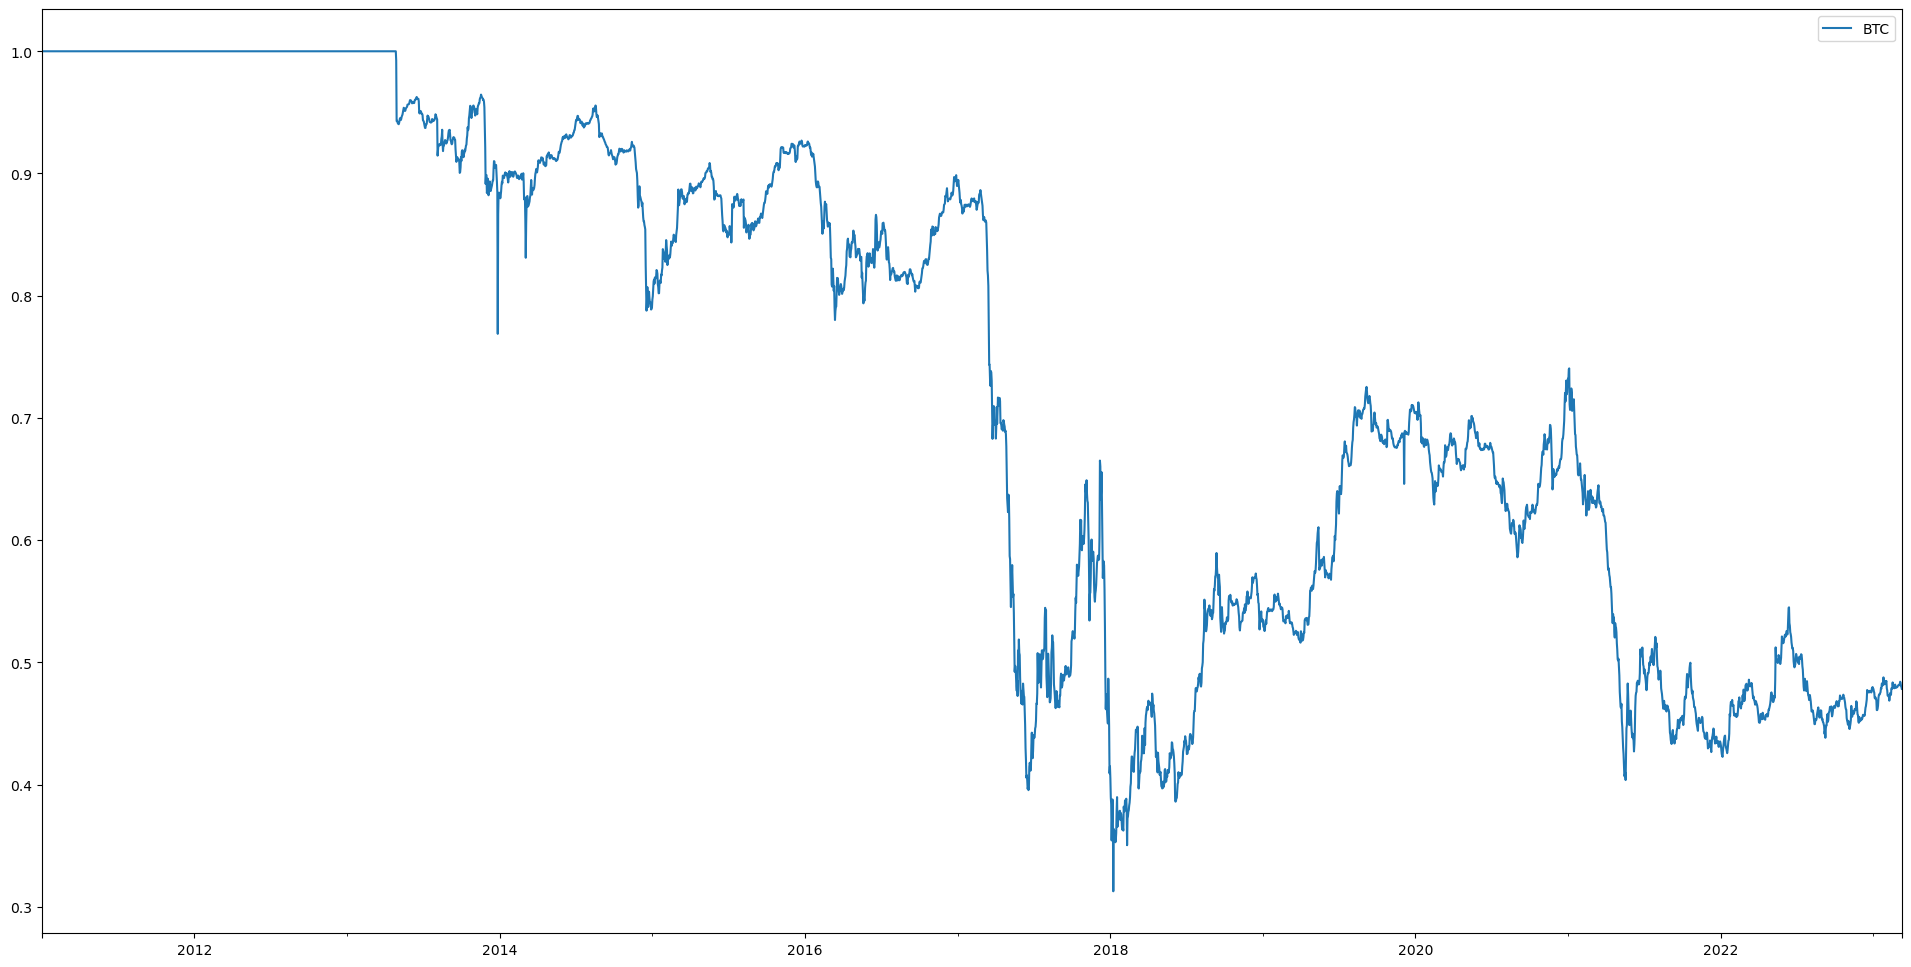

In [68]:
weight = mktcap.apply(lambda x: x / np.nansum(x), axis=1)
rtn = price.pct_change(fill_method=None) * np.sign(price)
weight[["BTC"]].plot(figsize=(24,12));

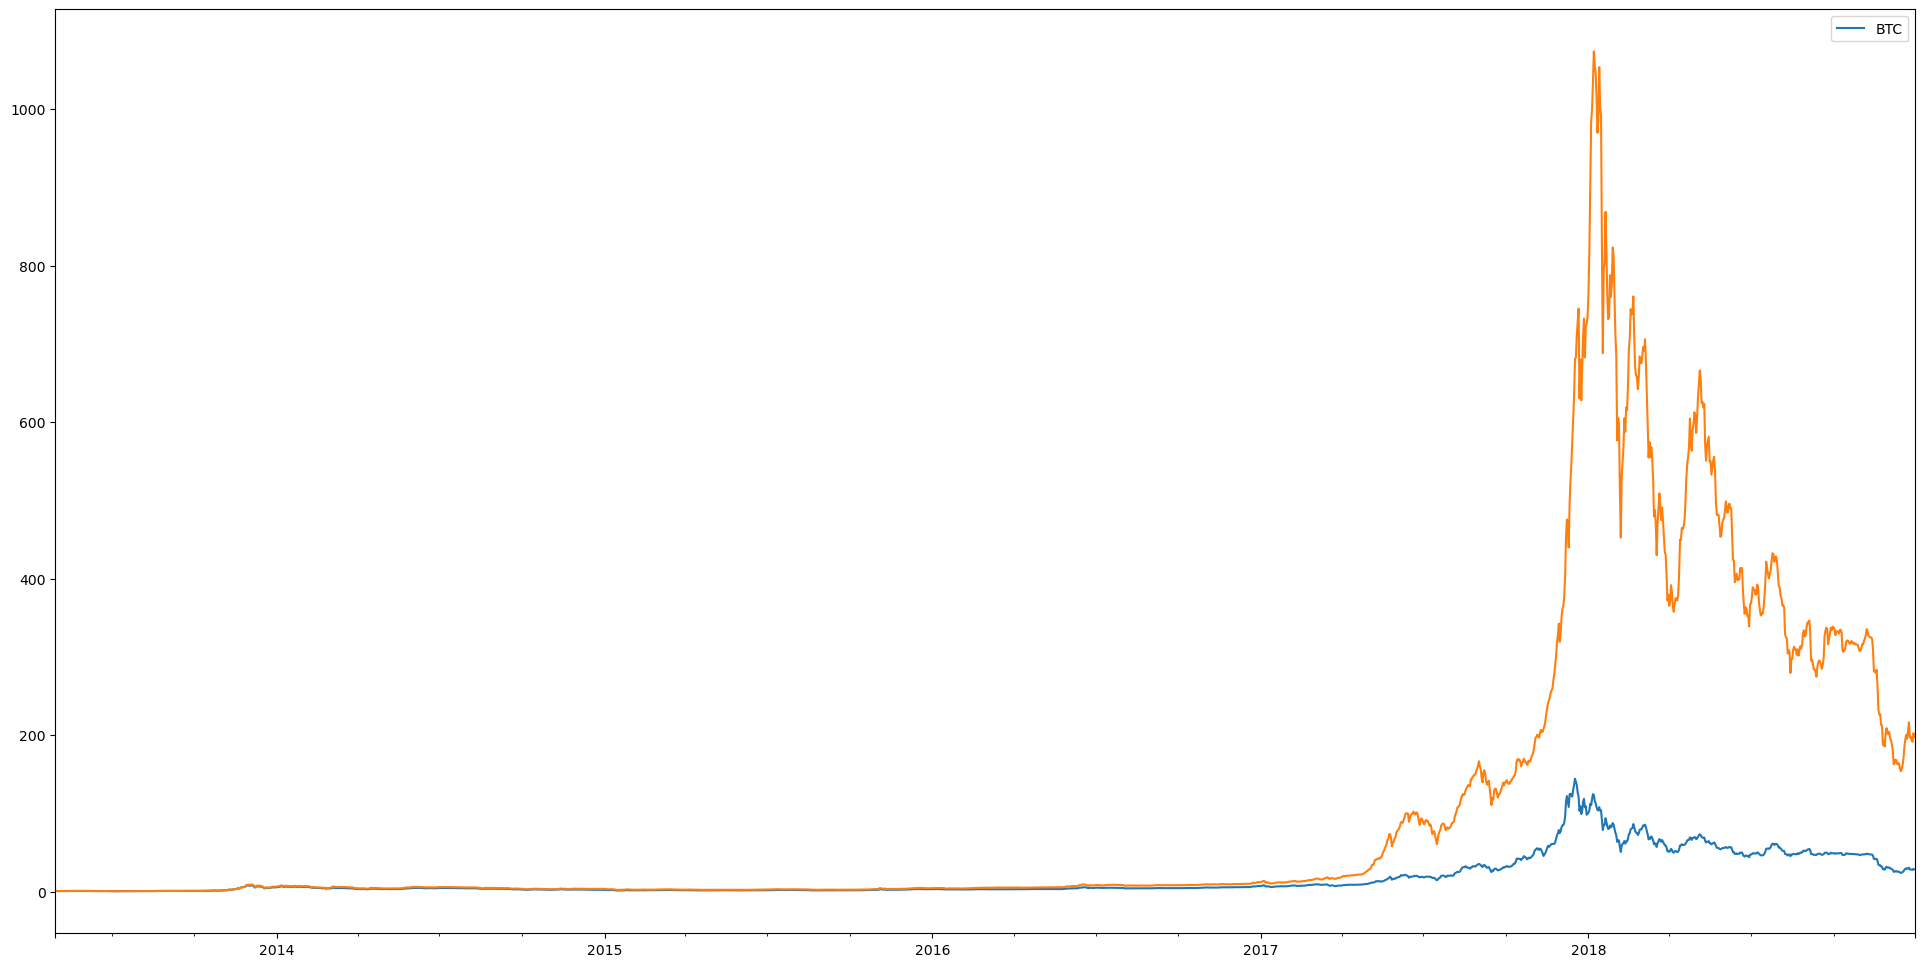

In [70]:
# Paper랑 똑같은 그림 (Figure 2) 그려보기

btc = (rtn)[["BTC"]].loc["2013-04-29":"2018"]

(btc + 1).cumprod().plot(figsize=(24,12));

((rtn * weight).sum(1) + 1).loc["2013-04-29":"2018"].cumprod().plot(figsize=(24,12));